# **Karras Pre-Conditioning**

In [1]:
import os, timm, torch, random, datasets, math, fastcore.all as fc
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF, torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDIMScheduler, DDPMPipeline, DDPMScheduler

In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 85

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## **Paper Abstract**: Elucidating the Design Space of Diffusion-Based Models

The [paper](https://arxiv.org/abs/2206.00364) abstract states:

>We argue that the theory and practice of diffusion-based generative models are currently unnecessarily convoluted and seek to remedy the situation by presenting a design space that clearly separates the concrete design choices. This lets us identify several changes to both the sampling and training processes, as well as preconditioning of the score networks. Together, our improvements yield new state-of-the-art FID of 1.79 for CIFAR-10 in a class-conditional setting and 1.97 in an unconditional setting, with much faster sampling (35 network evaluations per image) than prior designs.
>
>To further demonstrate their modular nature, we show that our design changes dramatically improve both the efficiency and quality obtainable with pre-trained score networks from previous work, including improving the FID of a previously trained ImageNet-64 model from 2.07 to near-SOTA 1.55, and after re-training with our proposed improvements to a new SOTA of 1.36.

In short, the authors take a much more explicit look at the concept of input scaling during the Diffusion process with the loss function evolving as follows:

![title](imgs/karras-preconditioning.png)

## **Load and Prepare Data**

In [4]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)

In [5]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)

dl = dls.train
xb, yb = b = next(iter(dl))

In [6]:
# Taking the standard deviation of the input data as sigma. Bear in mind that the inplace tfms
# will have an impact on this value.
sig_data = 0.66

The paper's premise is based on the notion that predicting noise may not be the correct approach for a variety of situations. Alternatively, the same can be said for predicting clean images, given clean inputs. The network needs to be given a properly _weighted_ problem to solve. 

Karras et al. introduce `c_skip`, in the effective training target component, which effectively carries out a Lerp (Linear Interpolation) of the two types of training targets i.e. clean images and pure noise. `c_skip` is a function of sigma and it replaces `alphabar`; while this simplifies the equation significantly - we need to pay attention to the fact that the existing symbol of sigma is being used for a completely different purpose here.

This plot from the paper shows the interpolation at work:

<div>
<img src="imgs/karras-sigma.png" width="650"/>
</div>

For noisy inputs, _effective training target_ values will be really small. Conversely, clean images will yeild higher values.

In [7]:
def scalings(sig):
    # Total variance at some level of sigma
    totvar = sig**2 + sig_data**2
               #c_skip         -        c_out              -     c_in
    return sig_data**2 / totvar, sig*sig_data/totvar.sqrt(), 1/totvar.sqrt()

In [8]:
# Creating a distribution of sigmas
# The distribution will be log normal
sig_samp = (torch.randn([10000])*1.2-1.2).exp()

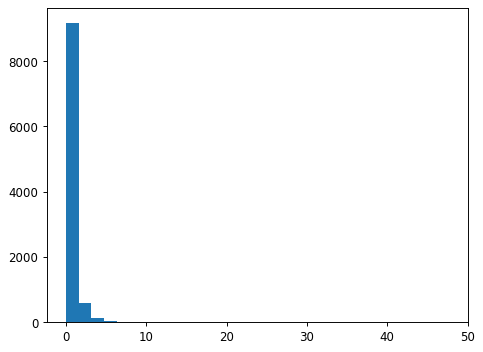

In [9]:
plt.hist(sig_samp, bins=30);

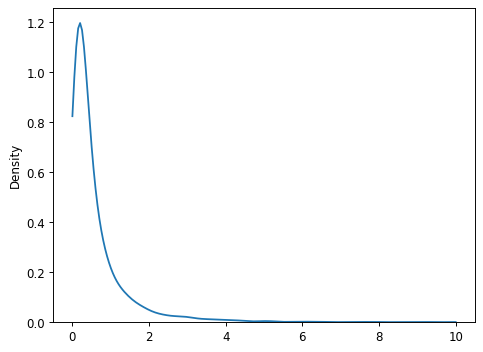

In [10]:
# Plotting the same using the KDE plot
sns.kdeplot(sig_samp, clip=(0, 10));

In [11]:
def noisify(x0):
    device = x0.device
    # Pick a sigma from a log normal distribution
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1,1,1,1)
    noise = torch.randn_like(x0, device=device)
    # Calculating values to pick an input between a clean image and noise
    c_skip, c_out, c_in = scalings(sig)
    noised_input = x0 + noise*sig
    # The target is based on a mixture of both noise and clean images with scaling
    # being done by c_out
    target = (x0-c_skip*noised_input)/c_out
    # Noised input is scaled up or down using c_in
    return (noised_input*c_in, sig.squeeze()), target

In [12]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=8)

In [13]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [14]:
dl = dls.train
(noised_input, sig), target = b = next(iter(dl))

To illustrate how this works, we can plot inputs from a batch. For very low levels of sigma (for e.g. image 3x3), the model will predict the noise. Whereas for very noisy inputs (for e.g. image 4x3) the model will predict the image. For images which have a roughly equivalent amount of noise and clean data (for e.g. image 3x2) then the model will predict both.

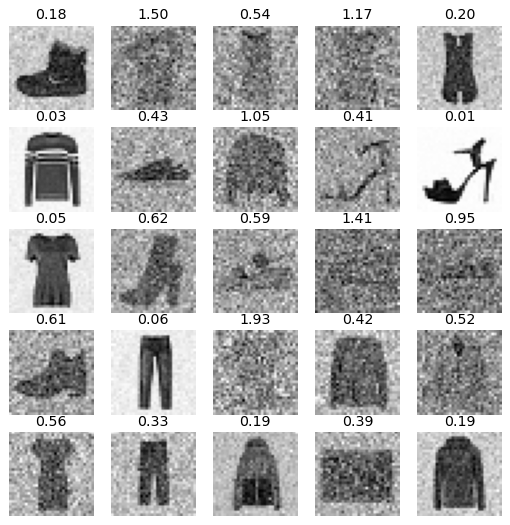

In [15]:
show_images(noised_input[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

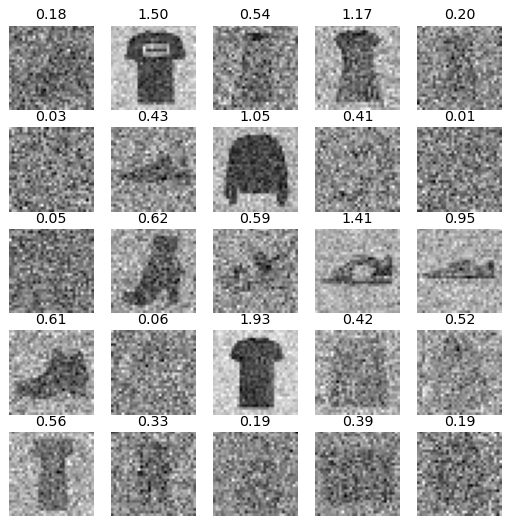

In [16]:
# Displaying the target images
show_images(target[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

In [17]:
noised_input.mean(), noised_input.std(), target.mean(), target.std()

(tensor(-0.69019), tensor(1.01665), tensor(-0.40007), tensor(1.03293))

## **Train Model**

In [18]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [19]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [20]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.604,0,train
0.299,0,eval
0.242,1,train
0.212,1,eval
0.205,2,train
0.193,2,eval
0.184,3,train
0.184,3,eval
0.179,4,train
0.183,4,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


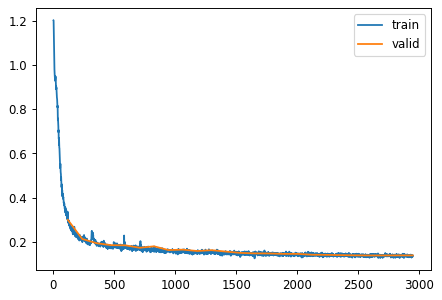

In [26]:
learn.fit(epochs)

In [21]:
#torch.save(learn.model, 'models/fashion_karras.pkl')
model = learn.model = torch.load('models/fashion_karras.pkl').cuda()

In [22]:
# Takes the output of noisify and denoises
def denoise(target, noised_input): return target*c_out + noised_input*c_skip 

In [23]:
with torch.no_grad():
    # Grab sigmas from the mini batch
    sigr = sig.cuda().reshape(-1, 1, 1, 1)
    # Calculate c_skip, c_in and c_out from the mini batch
    c_skip, c_out, c_in = scalings(sigr)
    # Model prediction based on noised input and sigmas
    targ_pred = learn.model((noised_input.cuda(), sig.cuda()))
    # Denoise predictions
    x0_pred = denoise(targ_pred, noised_input.cuda() / c_in)

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


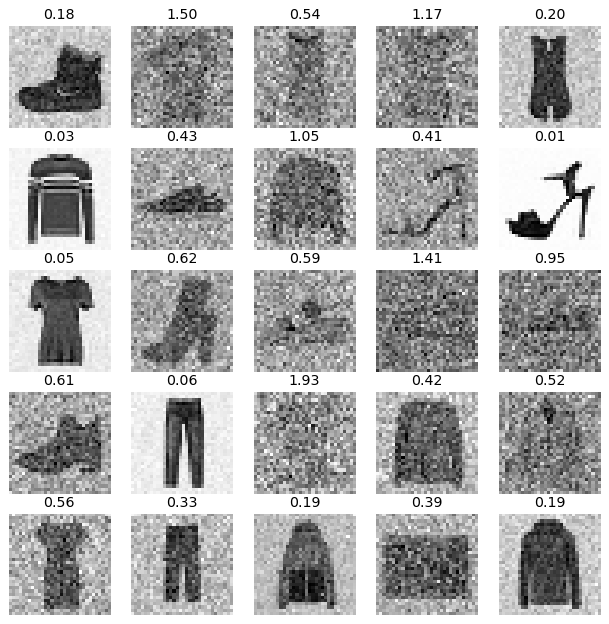

In [24]:
show_images(noised_input[:25], imsize=1.8, titles=fc.map_ex(sig[:25], '{:.02f}'))

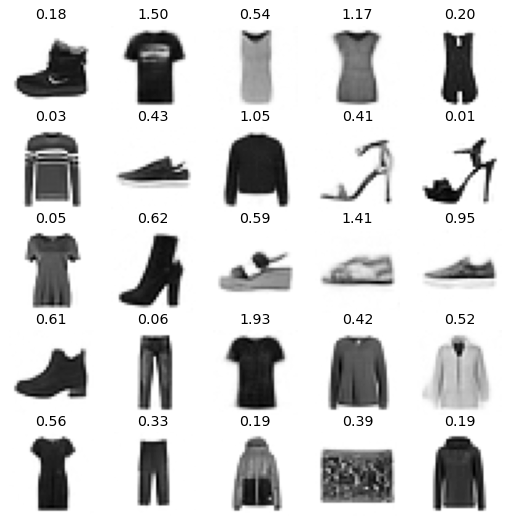

In [25]:
show_images(x0_pred[:25].clamp(-1,1), imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

Looking at the actuals, we can see that this approach generates remarkably good images. The model even manages to capture small details like text being printed on the front of a t-shirt.

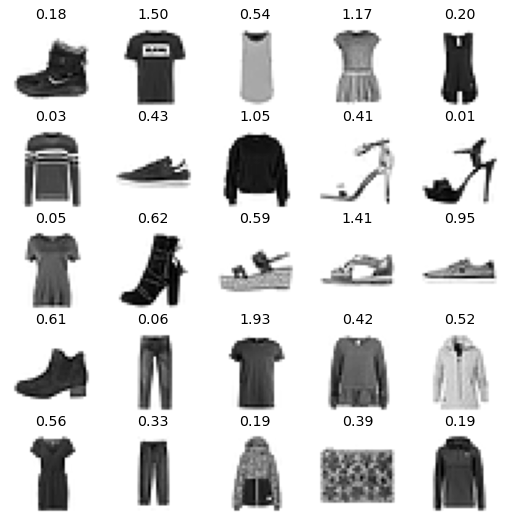

In [26]:
show_images(denoise(target.cuda(), noised_input.cuda()/c_in)[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

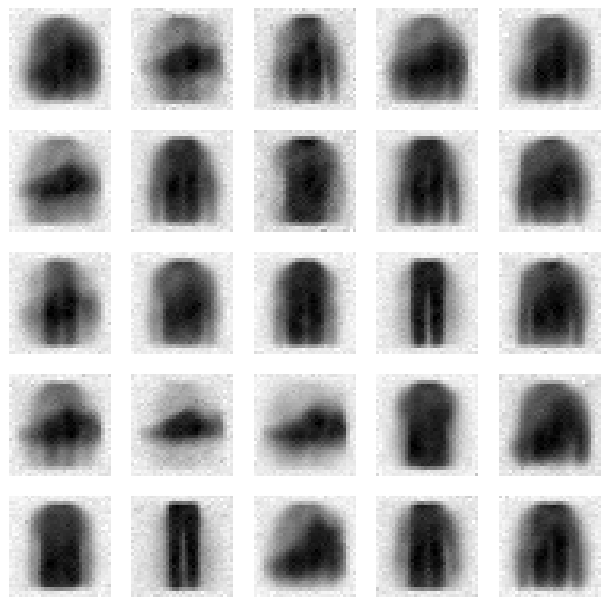

In [27]:
# In the paper, the pure noise level is sigma=80
# We can plot what this would look like.
sig_r = tensor(80.).cuda().reshape(-1, 1, 1, 1)
c_skip, c_out, c_in = scalings(sig_r)
x_r = torch.randn(32, 1, 32, 32).to(model.device)*sig_r

# Denoising for one step
with torch.no_grad():
    targ_pred = learn.model((x_r*c_in, sig_r.squeeze()))
    x0_pred = denoise(targ_pred, x_r)

show_images(x0_pred[:25], imsize=1.8)

In [28]:
x0_pred.max(), x0_pred.min(), x0_pred.mean(), x0_pred.std()

(tensor(0.58356, device='cuda:0'),
 tensor(-1.17754, device='cuda:0'),
 tensor(-0.53147, device='cuda:0'),
 tensor(0.45581, device='cuda:0'))

## **Sampling**

The paper makes the sampling process much simpler. 

Additionally, it is important to mention that alot of the sampling code has been adapted/taken from [Katherine Crowson's](https://github.com/crowsonkb/k-diffusion) exceptional work on K-Diffusion.

> Kat has some of the best code for generative modelling that I have ever seen. - Jeremy Howard.

In [29]:
from miniai.fid import ImageEval

In [30]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [ ]:
sz = (512,1,32,32)

In [31]:
sz = (2048,1,32,32)

This approach is a departure from how we've calculated sigmas / alphabars / ts in the past i.e. we used to take a linear approach to determine this value.

During sampling `sigmas_karras()` will ensure that we take large steps early on while moving to higher number of smaller steps later on in the training process. The mathematical foundations for this can be found in the appendix section of the [paper](https://arxiv.org/abs/2206.00364).

In [32]:
def sigmas_karras(n, sigma_min=0.01, sigma_max=80., rho=7., device='cpu'):
    ramp = torch.linspace(0, 1, n)
    # Defaulting to taking the 7th root of sigma. The paper suggests values 5 and above.
    min_inv_rho = sigma_min**(1/rho)
    max_inv_rho = sigma_max**(1/rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho))**rho
    return torch.cat([sigmas, tensor([0.])]).to(device)

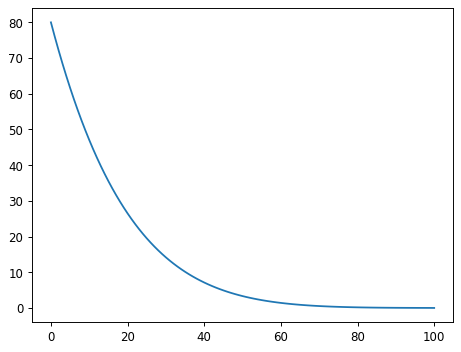

In [33]:
sk = sigmas_karras(100)
plt.plot(sk);

In [34]:
def denoise(model, x, sig):
    c_skip, c_out, c_in = scalings(sig)
    # Denoise using the model to scale the data with the above vals
    return model((x*c_in, sig))*c_out + x*c_skip

In [35]:
def get_ancestral_step(sigma_from, sigma_to, eta=1.): # Handles the randomness using eta to scale
    if not eta: return sigma_to, 0.
    var_to, var_from = sigma_to**2, sigma_from**2
    sigma_up = min(sigma_to, eta * (var_to * (var_from-var_to)/var_from)**0.5)
    return (var_to - sigma_up**2)**0.5, sigma_up

In [36]:
@torch.no_grad()
def sample_euler_ancestral(x, sigs, i, model, eta=1.): # Adds randomness to the scheduling process
    sig, sig2 = sigs[i], sigs[i+1]
    denoised = denoise(model, x, sig)
    sigma_down, sigma_up = get_ancestral_step(sig, sig2, eta=eta)
    x = x + (x-denoised)/sig*(sigma_down-sig)
    return x + torch.randn_like(x)*sigma_up

In [37]:
@torch.no_grad()
def sample_euler(x, sigs, i, model): # Deterministic scheduler
    sig, sig2 = sigs[i], sigs[i+1] # Sigmas given sampling steps
    denoised = denoise(model, x, sig) # Denoise based on steps
    # Outputs with directional results - results in a slope of noise per sigma 
    # multiplied by the change
    return x + (x-denoised)/sig*(sig2-sig) 

[Heun's method](https://en.wikipedia.org/wiki/Heun%27s_method) is a natural next step after testing the Euler approach.

In [38]:
@torch.no_grad()
def sample_heun(x, sigs, i, model, s_churn=0., s_tmin=0., s_tmax=float('inf'), s_noise=1.): # Multiple steps and tangent slopes, averaging afterwards.
    sig, sig2 = sigs[i], sigs[i+1]
    n = len(sigs)
    gamma = min(s_churn / (n-1), 2**0.5-1) if s_tmin <= sig <= s_tmax else 0.
    eps = torch.randn_like(x) * s_noise
    sigma_hat = sig * (gamma+1)
    if gamma > 0: x = x + eps * (sigma_hat**2 - sig**2)**0.5
    denoised = denoise(model, x, sig)
    d = (x - denoised) / sig
    dt = sig2 - sigma_hat
    x_2 = x + d*dt
    if sig2==0: return x_2
    denoised_2 = denoise(model, x_2, sig2)
    d_2 = (x_2 - denoised_2) / sig2
    d_prime = (d + d_2) / 2
    return x + d_prime*dt

In [39]:
def sample(sampler, model, steps=100, sigma_max=80., **kwargs):
    preds = []
    x = torch.randn(sz).to(model.device)*sigma_max # Create a pure noise image
    sigs = sigmas_karras(steps, device=model.device, sigma_max=sigma_max)
    for i in progress_bar(range(len(sigs)-1)):
        x = sampler(x, sigs, i, model, **kwargs)
        preds.append(x)
    return preds

In [50]:
# Euler sampler
#preds = sample(sample_euler, model, steps=100)
# Testing Huen and Ancestral samplers
#preds = sample(sample_euler_ancestral, model, steps=100, eta=0.5)
preds = sample(sample_heun, model, steps=100, s_churn=0.5)

In [51]:
s = preds[-1]
s.min(), s.max()

(tensor(-1.09858, device='cuda:0'), tensor(1.53323, device='cuda:0'))

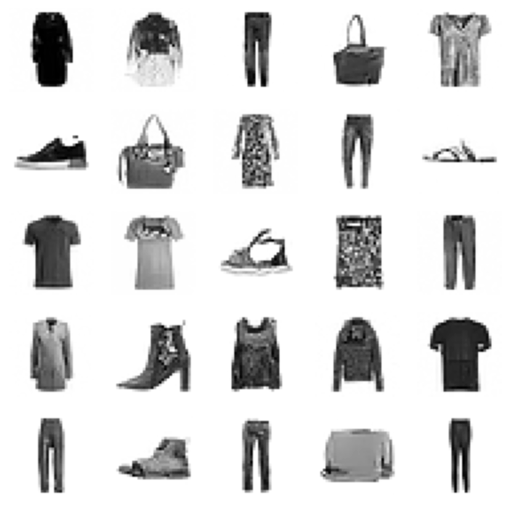

In [52]:
show_images(s[:25].clamp(-1,1), imsize=1.5)

In [43]:
# Tests - using Euler - 100  Steps
ie.fid(s), ie.kid(s), s.shape

(8.111083984375, 0.018905749544501305, torch.Size([2048, 1, 32, 32]))

In [48]:
# Tests - using Euler Ancestral - 100 Steps - eta 0.5
ie.fid(s), ie.kid(s), s.shape

(7.2015380859375, 0.019321540370583534, torch.Size([2048, 1, 32, 32]))

In [53]:
# Tests - using Heun - 100 Steps - churn 0.5
ie.fid(s), ie.kid(s), s.shape

(6.3406982421875, 0.009977945126593113, torch.Size([2048, 1, 32, 32]))

In [54]:
# Actuals
ie.fid(xb)

1.562744140625

In [ ]:
from scipy import integrate

In [ ]:
def linear_multistep_coeff(order, t, i, j):
    if order-1 > i: raise ValueError(f'Order {order} too high for step {i}')
    def fn(tau):
        prod = 1.
        for k in range(order):
            if j==k: continue
            prod *= (tau - t[i-k]) / (t[i-j] - t[i-k])
        return prod
    return integrate.quad(fn, t[i], t[i+1], epsrel=1e-4)[0]

In [ ]:
@torch.no_grad()
def sample_lms(model, steps=100, order=4, sigma_max=80.):
    preds = []
    x = torch.randn(sz).to(model.device)*sigma_max
    sigs = sigmas_karras(steps, device=model.device, sigma_max=sigma_max)
    ds = []
    for i in progress_bar(range(len(sigs)-1)):
        sig = sigs[i]
        denoised = denoise(model, x, sig)
        d = (x - denoised) / sig
        ds.append(d)
        if len(ds) > order: ds.pop(0)
        cur_order = min(i+1, order)
        coeffs = [linear_multistep_coeff(cur_order, sigs, i, j) for j in range(cur_order)]
        x = x + sum(coeff*d for coeff, d in zip(coeffs, reversed(ds)))
        preds.append(x)
    return preds

In [ ]:
# Tests for LMS